In [276]:
#pip install regex
# pip install praw

In [277]:
clear()

In [278]:
# Let's import our libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import praw
import regex as re 

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

from warnings import simplefilter
# Optionally turn off warnings once the models are producing good results
#   non convergence may mean the result is not perfect, but it might be good enough
# Credit to Jamie Shaffer
simplefilter("ignore", category=0)

In [279]:
# This class is used to pull data from Reddit and then create a DataFrame, it also loads the lastest csv into a dataframe

class reddit_getter:
    def __init__(self, sub):
        # This initalizes and loads all our past datasets
        self.subreddit = sub
        self.submits = 1000
        self.time_filter = 'day'
        self.reddit = praw.Reddit(client_id = 'oZRFffq6V4xYMg',
                    client_secret = 'O_p5-j5D3fYEa58nqMOwHnGZw0E',
                    username = 'the_illuminati_666',
                    user_agent = 'nothing_nefarious')
        self.dframe = pd.read_csv('../data_files/combined_reddit_data.csv')
    
    # This function can be called to pull data from Reddit, provided a submission_getter object has been created
    def get(self):
        comment_dict = {}
        subreddit = self.reddit.subreddit(self.subreddit)
        reddit_data = subreddit.top(time_filter = self.time_filter, limit = self.submits)
        print(f'Subreddit We Are Mining: {self.subreddit}, Time Filter: {self.time_filter}')
        for submission in reddit_data:
            # sometimes the submission.stickied method throws an error, we'll use a try and except in case
            try:
                if not submission.stickied:
                    comment_dict.update({submission.id : [submission.title, submission.author, subreddit.title, submission.num_comments, str(self.time_filter)]})          
            except:
                pass
        df = pd.DataFrame.from_dict(data = comment_dict, orient = 'index', columns = ['Submission Title', 'Submission Author', 'Subreddit', 'Number of Comments', 'Time Filter'])
        print('Returning DataFrame')
        return df
    

In [280]:
df_object = reddit_getter('Politics')
df = df_object.dframe
df.head()

,Submission Title,Submission Author,Subreddit,Number of Comments,Time Filter
0,Megathread: House Votes to Impeach President D...,PoliticsModeratorBot,Politics,52218,all
1,Virginia governor makes Election Day a holiday...,nclobo,Politics,4158,all
2,Video emerges showing Trump talking about cutt...,Nihilist911,Politics,4785,all
3,The Trump administration paid a bankrupt compa...,DaFunkJunkie,Politics,4809,all
4,Removed US coronavirus vaccine director files ...,grepnork,Politics,5089,all


In [281]:
# This class cleans and lemmatizes our sentences
class clean_sentences:
    def __init__(self, df):
        s = []
        i = 0
        df['Subreddit'] = df['Subreddit'].map({'Politics' : 1, 'Democrats: Stronger Together' : 0})
        for item in df['Submission Title']:
            
            
#             tokenizer = RegexpTokenizer("[a-zA-Z]")
            sentence = re.sub("[^a-zA-Z]", " ", item)
            words = sentence.lower().split()

            stops = set(stopwords.words('english'))
            extra_words = ['megathread', 'pre', 'com', 'mic', 'say', 'side', 'res', 'use']
            more_words = [word for word in words if ((word not in stops) and (word not in extra_words))]
            
            cleaned_sentence = " ".join(more_words)

            s.append(cleaned_sentence)

        df['cleaned_submissions'] = s

        lems = WordNetLemmatizer()
        lemmed = []
        for item in df['cleaned_submissions']:
            s_temp = ""
            s1 = item.split()
            lem_r = []
            # Turning of lemmatization
            for s in s1:
                lem = lems.lemmatize(s)
                if len(s) > 2:
                    lem_r.append(s)
#                 if len(lem) > 2:
#                     lem_r.append(lem)
            
            s_temp = " ".join(lem_r)
            
            lemmed.append(s_temp)
            
        df['lemmed'] = lemmed
        self.dframe = df

 

In [282]:
df_o = clean_sentences(df)

In [283]:
df = df_o.dframe

In [284]:
df.head()

,Submission Title,Submission Author,Subreddit,Number of Comments,Time Filter,cleaned_submissions,lemmed
0,Megathread: House Votes to Impeach President D...,PoliticsModeratorBot,1,52218,all,house votes impeach president donald j trump,house votes impeach president donald trump
1,Virginia governor makes Election Day a holiday...,nclobo,1,4158,all,virginia governor makes election day holiday e...,virginia governor makes election day holiday e...
2,Video emerges showing Trump talking about cutt...,Nihilist911,1,4785,all,video emerges showing trump talking cutting pa...,video emerges showing trump talking cutting pa...
3,The Trump administration paid a bankrupt compa...,DaFunkJunkie,1,4809,all,trump administration paid bankrupt company zer...,trump administration paid bankrupt company zer...
4,Removed US coronavirus vaccine director files ...,grepnork,1,5089,all,removed us coronavirus vaccine director files ...,removed coronavirus vaccine director files stu...


In [285]:
# Here were going to do some counting
bad_words = ['idiot', 'fool', 'dick', 'cock', 'bullshit', 'jackass', 'damn', 'fuck', 'shit', 'ass', 'bitch', 'asshole', 'faggot', 'cunt', 'motherfuck', 'motherfucker', 'stupid']
p_bad_counts = 0
d_bad_counts = 0
i = 0
p_dict = {}
p_list = []
politics_list = [string for string in df[df['Subreddit'] == 1]['lemmed']]
politics_string = ''
for item in politics_list:
    politics_string = politics_string + item
stuff1 = politics_string.split()
words_p = len(stuff1)

for s in stuff1:
    if s in bad_words:
        p_bad_counts += 1
    if s not in p_list:
        p_list.append(s)
        p_total = politics_string.count(s)

        p_dict.update({s : p_total})        
        
d_dict = {}
d_list = []
democrats_list = [string for string in df[df['Subreddit'] == 0]['lemmed']]
democrats_string = ''
for item in democrats_list:
    democrats_string = democrats_string + item

stuff2 = democrats_string.split(" ")
words_d = len(stuff2)

for s in stuff2:
    if s in bad_words:
        d_bad_counts += 1
    if s not in d_list:
        d_list.append(s)
        d_total = democrats_string.count(s)

        d_dict.update({s : d_total})            

In [286]:
print(f'The percentage of swear words in r/Politics is: {np.round(100*(p_bad_counts / words_p), 3)}%')
print(f'The percentage of swear words in r/Democrats is: {np.round(100*(d_bad_counts / words_d),3)}%')
print(f'Submitters to r/Democrats swear about {np.round((d_bad_counts / words_d) / (p_bad_counts / words_p), 1)} times as much as submitters to r/Politics.')

The percentage of swear words in r/Politics is: 0.029%
The percentage of swear words in r/Democrats is: 0.102%
Submitters to r/Democrats swear about 3.5 times as much as submitters to r/Politics.


In [287]:
# Build some dataframes
p_counts = pd.DataFrame.from_dict(data = p_dict, orient = 'index')

p_counts['word'] = p_counts.index

p_counts['count'] = p_counts[0]

p_counts.sort_values(by = 'count', ascending = False, inplace = True)
        
d_counts = pd.DataFrame.from_dict(data = d_dict, orient = 'index')

d_counts['word'] = d_counts.index

d_counts['count'] = d_counts[0]

d_counts.sort_values(by = 'count', ascending = False, inplace = True)

In [288]:
# Set our plotting perameters
font = {'family' : 'arial',
        'weight' : 'bold',
        'size'   : 15}

plt.rc('font', **font)
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 

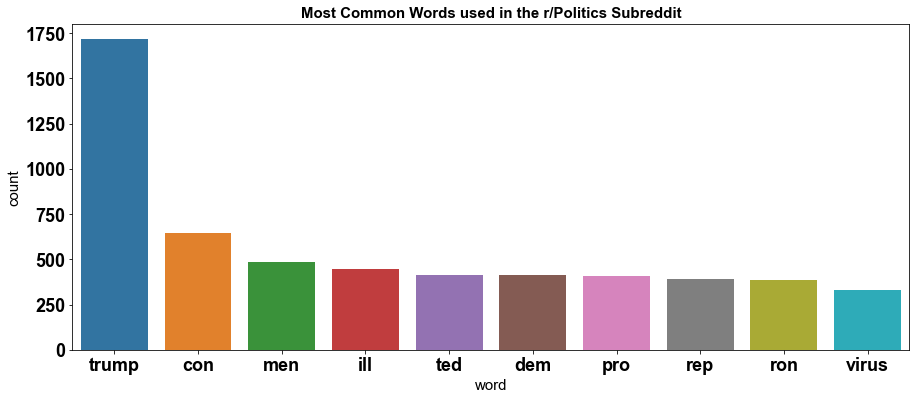

In [289]:
fig = plt.figure(figsize=(15,6))
sns.barplot(x=p_counts['word'].head(10), y=p_counts['count'].head(10))
plt.title('Most Common Words used in the r/Politics Subreddit', fontdict = font)
plt.show()

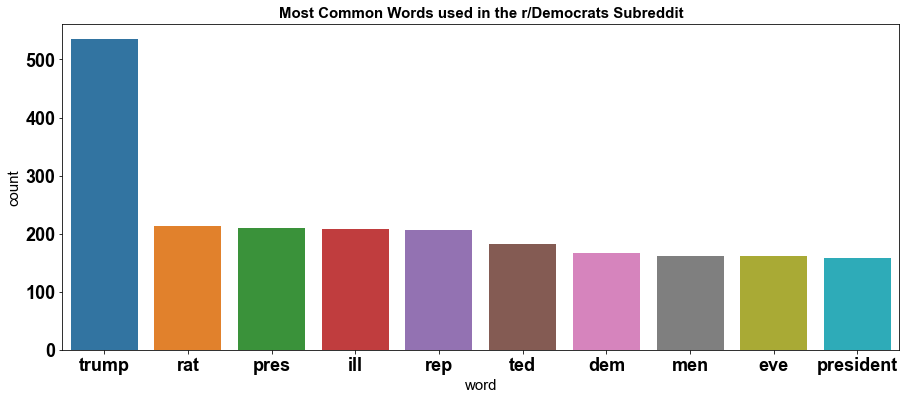

In [290]:
fig = plt.figure(figsize=(15,6))
sns.barplot(x=d_counts['word'].head(10), y=d_counts['count'].head(10))
plt.title('Most Common Words used in the r/Democrats Subreddit', fontdict = font)
plt.show()